# First Houzz notebook
- Nhan Le

In [35]:
from pyhive import presto
import pandas as pd
import matplotlib as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

from pyhive import presto
conn = presto.connect(host='presto-alpha-backend.data.houzz.net', port=8086)

## floor plans and mood board tables

In [17]:
# floor plan elements

def floor_plan_table_samples():
    floorplan_sql = '''
    SELECT floorplan_id, company_user_id, individual_user_id, created_at, created_dt, project_id, is_demo_project
    FROM hive.gaia.dim_floorplans
    ORDER BY 2, 3
    LIMIT 10
    '''
    floorplan_df = pd.read_sql(floorplan_sql, conn)

    floorplan_elem_sql = '''
    SELECT floorplan_element_id, floorplan_id, company_user_id, individual_user_id, created_at, created_dt, modified_at, modified_dt, "type", type_name
    FROM hive.gaia.dim_floorplan_elements
    ORDER BY 3, 5
    LIMIT 10
    '''
    floorplan_elem_df = pd.read_sql(floorplan_elem_sql, conn)

    fp_sql = """
    SELECT event_id, individual_user_id, visitor_id, client_id, experience_site_name, session_id, device_type, app_type, app_sub_type, browser_name, 
    flow_name, experience_name, event_source_section, event_source_container, event_source_component, event_timestamp, event_type, other_params, 
    other_ids, event_details, floorplan_id, company_user_id, mid, event_name, dt
    FROM hive.gaia.fact_floorplans
    ORDER BY 3, event_timestamp
    LIMIT 10"""
    floorplan_facts = pd.read_sql(fp_sql, conn)
    return floorplan_df, floorplan_elem_df, floorplan_facts

floor_plan_tables = floor_plan_table_samples()

In [121]:
# number of unique users by year

def users_count_by_month():
    floorplan_sql = '''
    WITH tb as (
        SELECT *, YEAR(created_at) year, MONTH(created_at) month
        FROM hive.gaia.dim_floorplans
        )
    , summary as (
        SELECT COUNT(distinct company_user_id) user_count, year, month
        FROM tb
        -- WHERE is_demo_project = "True"
        GROUP BY year, month
        ORDER BY year, month)
    SELECT *,
        --CONCAT(cast(year as varchar(4)), '_', cast(month as varchar(2))) period
        year*100 + month period
    FROM summary
    '''

    df =  pd.read_sql(floorplan_sql, conn)
    # df['period'] = df['year'].astype(str) + '_' + df['month'].astype(str)
    # df['year'] = df['year'].astype('category')
    # df.plot().bar(y='user_count', x = 'year', rot = 0)
    print('Note: Have NOT filtered out trial transactions')
    return df


Note: Have NOT filtered out trial transactions


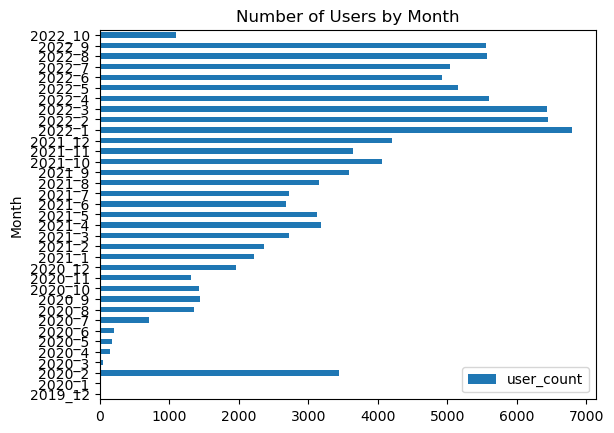

In [83]:
def make_horizontal_bar_chart(df, x, y, title, xlabel, ylabel, rot=0):
    df.plot.barh(
        x=x, y=y, rot=rot,
        title=title,
        xlabel=xlabel,
        ylabel=ylabel)


make_horizontal_bar_chart(users_count_by_month(), 'period', 'user_count', 'Number of Users by Month', 'Month', 'Number of Users')

In [122]:
def new_user_count_by_month():
    floorplan_sql = '''
    WITH tb as (
        SELECT *, 
        YEAR(min(created_at) over (partition by company_user_id)) first_transaction_year,
        MONTH(min(created_at) over (partition by company_user_id)) first_transaction_month
        FROM hive.gaia.dim_floorplans
        )
    , summary as (
        SELECT COUNT(distinct company_user_id) user_count, first_transaction_year, first_transaction_month
        FROM tb
        -- WHERE is_demo_project = "True"
        GROUP BY first_transaction_year, first_transaction_month
        ORDER BY first_transaction_year, first_transaction_month)
    SELECT *,
        --CONCAT(cast(first_transaction_year as varchar(4)), '_', cast(first_transaction_month as varchar(2))) period
        first_transaction_year*100 + first_transaction_month period
    FROM summary
    '''    
    df =  pd.read_sql(floorplan_sql, conn)
    df['period'] = df['first_transaction_year'].astype(str) + '_' + df['first_transaction_month'].astype(str)
    return df
    # df['period'] = (df['first_transaction_year']-2019)*4 + df['first_transaction_month']



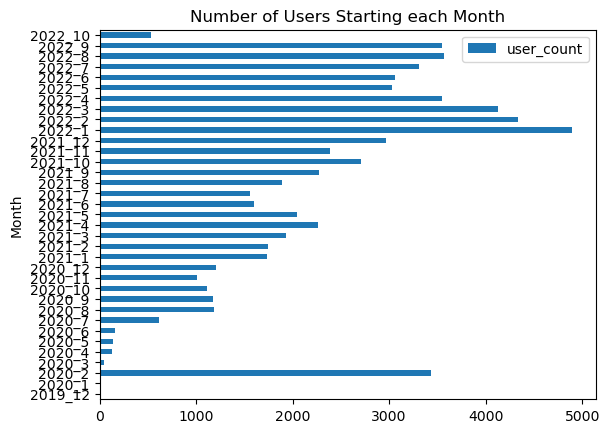

In [85]:
make_horizontal_bar_chart(new_user_count_by_month(), 'period', 'user_count', 'Number of Users Starting each Month', 'Month', 'Number of Users')

In [129]:
def combine_count_with_new_user_count():
    df = users_count_by_month().sort_values(by=['year', 'month'])
    df['new_user_count'] = new_user_count_by_month().sort_values(by=['first_transaction_year', 'first_transaction_month'])['user_count']
    return df

def plot_user_count_and_new_user_count_with_sns(df):
    import seaborn as sns
    # calculate repeated users = user_count - new_user_count
    df['repeated_user_count'] = df['user_count'] - df['new_user_count']
    # stack new_user_count and repeated_user_count
    df = df.melt(id_vars=['period'], value_vars=['new_user_count', 'repeated_user_count'])
    # place dash between year and month in period
    df['period'] = df['period'].astype(str).str[:4] + '-' + df['period'].astype(str).str[4:]
    # plot
    sns.set(style="whitegrid")
    ax = sns.barplot(
        x="period", y="value", hue="variable", data=df,
        # stack categories
        dodge=True,
        )
    # rotate x labels
    for item in ax.get_xticklabels():
        item.set_rotation(60)

    ax.set_title('Number of Users Starting each Month')
    ax.set_xlabel('Month')
    ax.set_ylabel('Number of Users')
    # legend remove title, make colors consistent with bar colors
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles, labels=['New User', 'Existing User'], title='')
    # ax.legend(handles=handles[1:], labels=labels[1:], title='', facecolor='white', edgecolor='white')


Note: Have NOT filtered out trial transactions


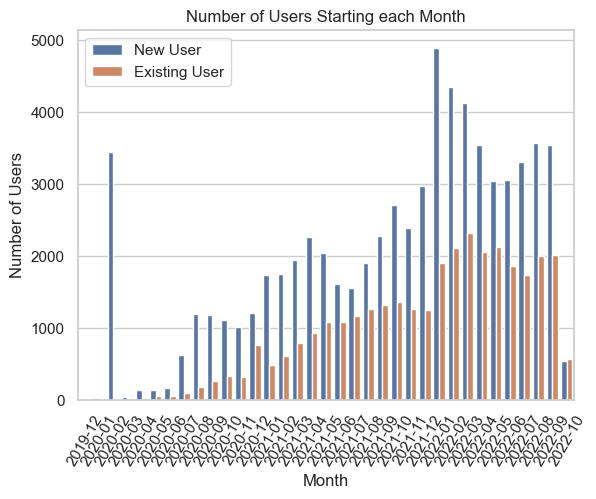

In [130]:
plot_user_count_and_new_user_count_with_sns(combine_count_with_new_user_count())

Note: Have NOT filtered out trial transactions


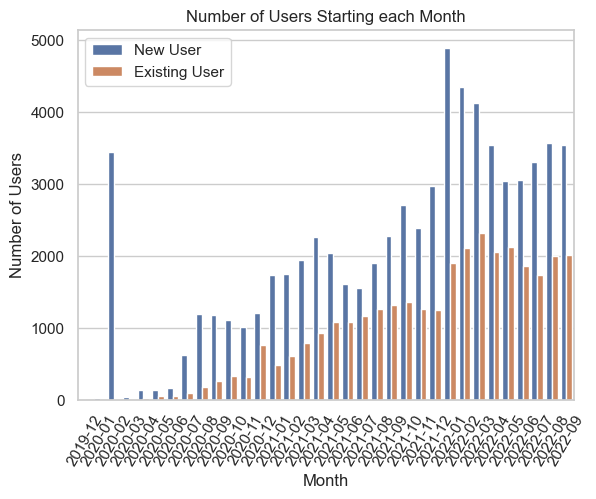

In [131]:
# freeze chart to period priod to 2022_9 for comparison later
def freeze_chart_to_period(year, month):
    df = combine_count_with_new_user_count()
    df = df[df['period'] <= year*100 + month]
    df['new_user_count'] = new_user_count_by_month().sort_values(by=['first_transaction_year', 'first_transaction_month'])['user_count']
    return df

plot_user_count_and_new_user_count_with_sns(freeze_chart_to_period(2022, 9))

## explore gaia.dim_company_user_sku_ranges to find paying status

In [191]:
# open gaia.dim_company_user_sku_ranges from hive
def open_company_user_sku_ranges():
    sku_sql = '''
    with comp as (
        SELECT * 
        -- number of start_dt for each company_user_id
        , COUNT(start_dt) OVER (PARTITION BY company_user_id) AS num_policies_started
        , ROW_NUMBER() OVER (PARTITION BY company_user_id ORDER BY start_dt) AS policy_num
        -- first join and last active
        , MIN(date(start_dt)) OVER (PARTITION BY company_user_id) AS first_join_dt
        , MAX(date(end_dt)) OVER (PARTITION BY company_user_id) AS last_active_dt
        -- get first and last free_or_paying status
        , FIRST_VALUE(free_or_paying) OVER (PARTITION BY company_user_id ORDER BY start_dt) AS first_status
        , FIRST_VALUE(free_or_paying) OVER (PARTITION BY company_user_id ORDER BY end_dt DESC) AS last_status
        -- paying vs not-paying
        , CASE WHEN free_or_paying = 'paying' THEN 'paying' ELSE 'not-paying' END AS paying_status
        -- lagged status
        , LAG(free_or_paying) OVER (PARTITION BY company_user_id ORDER BY start_dt) previous_status
        -- next status
        , LEAD(free_or_paying) OVER (PARTITION BY company_user_id ORDER BY start_dt) next_status

  
        FROM hive.gaia.dim_company_user_sku_ranges
        )

    , companies as (
        SELECT  fp.floorplan_id, fp.company_user_id, fp.individual_user_id, fp.created_at -- ,project_id, is_demo_project
        -- identify overlapping floorplans
        , coalesce(date_diff('minute', lag(fp.created_at) over(partition by fp.company_user_id order by fp.created_at), fp.created_at), 2) as minutes_since_prev
        -- create dynamic status column
        , CONCAT(FIRST_VALUE(comp.paying_status) OVER (PARTITION BY comp.company_user_id ORDER BY comp.start_dt), ' first', 
                FIRST_VALUE(comp.paying_status) OVER (PARTITION BY comp.company_user_id ORDER BY comp.end_dt DESC), ' later') AS dynamic_status  
                
        , comp.sku, comp.start_dt, comp.end_dt, comp.is_still_live, comp.free_or_paying, comp.num_policies_started, comp.policy_num, comp.first_status, comp.last_status, comp.previous_status
        , comp.first_join_dt, comp.last_active_dt
        , CASE WHEN date(fp.created_at) < first_join_dt THEN first_join_dt 
                ELSE CASE WHEN date(fp.created_at) > last_active_dt THEN last_active_dt 
                    ELSE date(fp.created_at) END 
                    END  AS created_dt
        
        -- to match start and end dates with floorplans, first left outer join then keep only rows where created_dt is between start_dt and end_dt    
        FROM hive.gaia.dim_floorplans fp LEFT OUTER JOIN comp ON fp.company_user_id = comp.company_user_id
        WHERE CASE WHEN date(fp.created_at) < first_join_dt THEN first_join_dt 
                ELSE CASE WHEN date(fp.created_at) > last_active_dt THEN last_active_dt 
                    ELSE date(fp.created_at) END 
                    END 
            >= date(comp.start_dt) 
        AND CASE WHEN date(fp.created_at) < first_join_dt THEN first_join_dt 
                ELSE CASE WHEN date(fp.created_at) > last_active_dt THEN last_active_dt 
                    ELSE date(fp.created_at) END 
                    END 
            <= date(comp.end_dt)
        )
    select * from companies

    ORDER BY company_user_id, created_at
    
    limit 50'''
    df =  pd.read_sql(sku_sql, conn)
    return df

open_company_user_sku_ranges()

,floorplan_id,company_user_id,individual_user_id,created_at,minutes_since_prev,dynamic_status,sku,start_dt,end_dt,is_still_live,free_or_paying,num_policies_started,policy_num,first_status,last_status,previous_status,first_join_dt,last_active_dt,created_dt
0,177545514,284,284,2021-10-05 15:56:54.000,2,paying firstpaying later,Ultimate,2020-03-11,2022-10-10,1,paying,2,2,paying,paying,paying,2020-01-01,2022-10-10,2021-10-05
1,187449848,1176,1176,2022-06-18 01:30:41.000,2,not-paying firstnot-paying later,Freemium 1.0,2021-08-26,2022-10-10,0,freemium,1,1,freemium,freemium,None,2021-08-26,2022-10-10,2022-06-18
2,165292500,3665,3665,2020-10-13 18:30:43.000,2,not-paying firstnot-paying later,Freemium 1.0,2021-08-26,2022-10-10,0,freemium,1,1,freemium,freemium,None,2021-08-26,2022-10-10,2021-08-26
3,186005175,4218,4218,2022-04-28 20:18:40.000,2,not-paying firstnot-paying later,Freemium 1.0,2021-08-26,2021-09-17,0,freemium,1,1,freemium,freemium,None,2021-08-26,2021-09-17,2021-09-17
4,190811303,4263,4263,2022-10-03 02:10:02.000,2,not-paying firstnot-paying later,Paying Ent. Without SFDC Sku,2022-10-02,2022-10-10,0,freemium,1,1,freemium,freemium,None,2022-10-02,2022-10-10,2022-10-03
5,182853166,5606,5606,2022-01-23 22:11:18.000,2,not-paying firstnot-paying later,Essential,2022-01-23,2022-02-10,0,free trial,1,1,free trial,free trial,None,2022-01-23,2022-02-10,2022-01-23
6,171181871,8683,8683,2021-03-30 19:11:38.000,2,paying firstpaying later,Ultimate,2021-02-17,2022-10-10,1,paying,1,1,paying,paying,None,2021-02-17,2022-10-10,2021-03-30
7,177458481,9280,9280,2021-10-01 18:14:50.000,2,not-paying firstnot-paying later,Starter,2021-09-10,2021-10-05,0,free trial,1,1,free trial,free trial,None,2021-09-10,2021-10-05,2021-10-01
8,177837784,9739,9739,2021-10-13 23:25:26.000,2,paying firstpaying later,Ultimate,2021-10-13,2022-10-10,1,paying,2,2,paying,paying,paying,2020-01-01,2022-10-10,2021-10-13
9,177880049,9739,9739,2021-10-15 20:10:14.000,2684,paying firstpaying later,Ultimate,2021-10-13,2022-10-10,1,paying,2,2,paying,paying,paying,2020-01-01,2022-10-10,2021-10-15


## explore Naama's code to count active companies by cohorts

In [209]:
# quick look at gaia.dim_company_users:

# additional info to exploit:
    # geo info
    # metro areas
    # whether or not they have domain
pd.read_sql('select * from hive.gaia.dim_company_users limit 10', conn).columns

Index(['company_user_id', 'account_email', 'has_profile',
       'account_created_date', 'professional_id', 'user_name', 'company_name',
       'user_first_name', 'user_last_name', 'address', 'city', 'state',
       'country', 'country_top', 'zip', 'phone', 'profile_email',
       'houzz_profile_url', 'domain', 'profile_created_date', 'metro_area',
       'pro_type_title', 'pro_meta_category', 'ivy_company_type',
       'is_likely_houzzer', 'clipper_installed_dt'],
      dtype='object')

In [215]:
pd.read_sql('select * from hive.gaia.dim_company_user_sku_ranges limit 10', conn)

,company_user_id,sku,free_or_paying,origin,start_dt,end_dt,is_still_live
0,199,Freemium 1.0,freemium,ads.pro_plus_professionals_ext_daily,2021-08-26,2022-10-10,0
1,262,Freemium 1.0,freemium,ads.pro_plus_professionals_ext_daily,2021-08-26,2022-10-10,0
2,1208,Freemium 1.0,freemium,ads.pro_plus_professionals_ext_daily,2021-08-26,2022-10-10,0
3,2632,Freemium 1.0,freemium,ads.pro_plus_professionals_ext_daily,2021-08-26,2022-10-10,0
4,2671,Freemium 1.0,freemium,ads.pro_plus_professionals_ext_daily,2021-08-26,2022-10-10,0
5,11006,Freemium 1.0,freemium,ads.pro_plus_professionals_ext_daily,2021-08-26,2022-10-10,0
6,12530,Freemium 1.0,freemium,ads.pro_plus_professionals_ext_daily,2021-08-26,2022-10-10,0
7,13240,Freemium 1.0,freemium,ads.pro_plus_professionals_ext_daily,2021-08-26,2022-10-10,0
8,14205,Freemium 1.0,freemium,ads.pro_plus_professionals_ext_daily,2021-08-26,2022-10-10,0
9,18069,Freemium 1.0,freemium,ads.pro_plus_professionals_ext_daily,2021-08-26,2022-10-10,0


In [208]:
date = '2021-01-01'
event = 'floorplan created'
is_demo_project = 'without demo proj'
country = 'US'

sql = '''
WITH    
time_frame AS (    
SELECT date('{0}')
),

-- get join_date as first start_dt in paying status
join_date AS (
      select company_user_id, sku, country, pro_type, join_date 
      from
            (
            select company_user_id, sku, country, pro_type, start_dt as join_date
            from (
                  -- dim_company_user_sku_ranges provides start_dt, country, sku, and free_or_paying
                  -- dim_company_users has ivy_company_type and is_likely_houzzer 
                  select  s.company_user_id
                        , s.start_dt 
                        , s.account_created_date
                        sku,
                        case when country = 'AU' then 'AU'
                        when country = 'CA' then 'CA'
                        when country = 'DE' then 'DE'
                        when country = 'ES' then 'ES'
                        when country = 'FR' then 'FR'
                        when country = 'GB' then 'GB'
                        when country = 'IE' then 'IE'
                        when country = 'IT' then 'IT'
                        when country = 'JP' then 'JP'
                        when country = 'NZ' then 'NZ'
                        when country = 'RU' then 'RU'
                        when country = 'US' then 'US'
                        else 'Other' end as country,
                        ivy_company_type as pro_type,
                        row_number() over(PARTITION BY s.company_user_id
                                          ORDER BY start_dt ASC) AS row_num
                  from gaia.dim_company_user_sku_ranges s 
                  join gaia.dim_company_users c 
                  on s.company_user_id = c.company_user_id
                  where free_or_paying = 'paying'
                        and NOT c.is_likely_houzzer 
                        and c.ivy_company_type <> 'Not in ivy'
                  )a
            where row_num = 1
            )b
      where date(join_date) >= (SELECT * FROM time_frame)
)
,

-- get ft_date as first day in free trial status
ft as ( 
      select company_user_id, sku, ft_date from (
            select company_user_id, sku, start_dt as ft_date
            from (
                  select  s.company_user_id, 
                        start_dt,
                        sku,
                        row_number() over(PARTITION BY s.company_user_id
                                          ORDER BY start_dt ASC) AS row_num
                              
                  from gaia.dim_company_user_sku_ranges s 
                  join gaia.dim_company_users c 
                  on s.company_user_id = c.company_user_id
                  where free_or_paying = 'free trial'
                        and NOT c.is_likely_houzzer 
                        and c.ivy_company_type <> 'Not in ivy'
                  )a
      where row_num = 1
      )b
),

-- distinguish between companies who ever did free try
first as
(
select jd.*
, case when ft.ft_date is null then 'not_ft' else 'ft' end as ever_ft
from join_date jd 
left join ft 
on jd.company_user_id = ft.company_user_id
),

-- get unique company_user_id whose activities showed up in a given month
activity as (
      select date(date_trunc('month', date(a.created_dt))) as activity_month
            , a.company_user_id AS unique_id
            , date(date_trunc('month', date(f.join_date))) as join_date
      from gaia.report_pro_creations_user_day_summary a 
      join gaia.dim_company_users c 
            on a.company_user_id = c.company_user_id       
      join first f 
            on a.company_user_id = f.company_user_id
      where NOT c.is_likely_houzzer 
            and c.ivy_company_type <> 'Not in ivy'
            and a.event in ('{1}')
            and a.includes_demo_projects = '{2}'
            and date(a.created_dt) >= date(join_date)
            --and f.sku in ({{sku}})
            --and f.ever_ft in ({{ever_ft}})
            --and f.country in ({3})
            --and f.pro_type in ({{pro_type}})
      group by 1,2,3     
),

population_agg as
(
select date(date_trunc('month', date(join_date))) as join_date, -- month of join_date
       count(company_user_id) AS total                          -- total number of companies
from first
--where sku in ({{sku}})
--      and ever_ft in ({{ever_ft}})
--      and country in ({3})
--      and pro_type in ({{pro_type}})
group by 1
)

select *
from
(
select a.join_date,
       date_diff('month', a.join_date, a.activity_month) as month_number,     -- month number since join_date
       count(distinct a.unique_id) AS value,                                  -- number of companies who did floorplan in that month
       p.total                                                                -- total number of companies joining in the month of join_date
from activity a 
join population_agg p 
      on a.join_date = p.join_date
GROUP BY 1, 2, 4
)a
--where month_number <> 0
order by 1 desc,2,3
'''.format(date, event, is_demo_project, country)


pd.read_sql(sql, conn).head(10)

,join_date,month_number,value,total
0,2022-10-01,0,62,713
1,2022-09-01,0,310,2294
2,2022-09-01,1,125,2294
3,2022-08-01,0,270,2054
4,2022-08-01,1,283,2054
5,2022-08-01,2,83,2054
6,2022-07-01,0,229,1953
7,2022-07-01,1,239,1953
8,2022-07-01,2,153,1953
9,2022-07-01,3,44,1953


In [373]:
def validate_floorplans():
    # sample data from floorplan elements
    # extract floorplans with company_user_id, created_dt
    # every floorplan has 9 (distinct) elements; must have at least one more to be considered "real"
    valid_fp_sql = '''
    with fp as (
        select floorplan_id, company_user_id, created_dt
            , count(floorplan_element_id) over (partition by floorplan_id) as fp_elements
            , min(date(created_dt)) over (partition by floorplan_id) as fp_created_dt 
            -- get 1 row per flooplan id
            , row_number() over (partition by floorplan_id) as row_num
        from gaia.dim_floorplan_elements 
        )
    , valid_floorplan as (select floorplan_id, company_user_id, created_dt, fp_created_dt, fp_elements
        , case when fp_elements > 9 then 'valid' else 'invalid' end as fp_status
    from fp
    where fp_elements > 9
    and row_num = 1
    order by floorplan_id, fp_created_dt
    )
    '''
    return valid_fp_sql
pd.read_sql(validate_floorplans() + 'select * from valid_floorplan limit 5' , conn)

,floorplan_id,company_user_id,created_dt,fp_created_dt,fp_elements,fp_status
0,152469592,210249,2019-12-10,2019-12-10,46,valid
1,152498473,57045505,2019-12-11,2019-12-11,20,valid
2,152500949,57045505,2019-12-11,2019-12-11,89,valid
3,152501711,57045505,2019-12-11,2019-12-11,63,valid
4,152736076,16821960,2019-12-17,2019-12-17,30,valid


In [454]:
def get_dim_companies(time_frame = '2020-01-01'): 
    # obtain country, pro_type, zip, metro area from dim_company_users
    # obtain sku, join_date from dim_company_user_sku_ranges
    # join_date is the first day of the month when the company first became paying customers
    dim_comp_sql = '''
    with dim_comp as (
        select company_user_id, join_date 
        from (
            select company_user_id, start_dt as join_date 
            from (
                -- dim_company_user_sku_ranges provides start_dt, country, sku, and free_or_paying
                -- dim_company_users has ivy_company_type and is_likely_houzzer 
                select  s.company_user_id
                    , s.start_dt 
                    , account_created_date
                    , row_number() over(PARTITION BY s.company_user_id
                                        ORDER BY start_dt ASC) AS row_num
                from gaia.dim_company_user_sku_ranges s 
                join gaia.dim_company_users c 
                on s.company_user_id = c.company_user_id
                where free_or_paying = 'paying'
                    and NOT c.is_likely_houzzer 
                    and c.ivy_company_type <> 'Not in ivy'
                )a
            where row_num = 1
            )b
        where date(join_date) >= date('{}')
    )

    -- get ft_date as first day in free trial status
    , ft as ( 
        select company_user_id, sku, country, pro_type, first_start_date, zip, metro_area, free_or_paying 
        from (
            select *,  start_dt as first_start_date
            from (
                select  s.*, zip, metro_area
                    --s.company_user_id, 
                    --start_dt,
                    --sku,
                    , case when country = 'AU' then 'AU'
                        when country = 'CA' then 'CA'
                        when country = 'DE' then 'DE'
                        when country = 'ES' then 'ES'
                        when country = 'FR' then 'FR'
                        when country = 'GB' then 'GB'
                        when country = 'IE' then 'IE'
                        when country = 'IT' then 'IT'
                        when country = 'JP' then 'JP'
                        when country = 'NZ' then 'NZ'
                        when country = 'RU' then 'RU'
                        when country = 'US' then 'US'
                        else 'Other' end as country

                    , ivy_company_type as pro_type 
                    , row_number() over(PARTITION BY s.company_user_id
                                        ORDER BY start_dt ASC) AS row_num
                            
                from gaia.dim_company_user_sku_ranges s 
                join gaia.dim_company_users c 
                on s.company_user_id = c.company_user_id
                where --free_or_paying <> 'paying' and 
                        NOT c.is_likely_houzzer 
                        and c.ivy_company_type <> 'Not in ivy'
                )a
        where row_num = 1
        )b
    )

    -- most recent is_still_live status
    , live as (
        select company_user_id, is_still_live
        from (  
            select *
            , row_number() over(PARTITION BY company_user_id ORDER BY end_dt DESC) AS row_num
            from gaia.dim_company_user_sku_ranges
            )a
        where row_num = 1
        )

    -- if paying customers are no longer live, get their last live date
    , last_live as (
        select company_user_id, end_dt as last_live_date
        from (  
            select *
            , row_number() over(PARTITION BY company_user_id ORDER BY end_dt DESC) AS row_num
            from gaia.dim_company_user_sku_ranges
            where free_or_paying = 'paying'
            )a
        where row_num = 1
        )        
    -- distinguish between companies who ever did free try
    ,first as (
        select ft.company_user_id, ft.country, ft.first_start_date, comp.join_date, ft.pro_type, ft.zip, ft.metro_area
            , case when first_start_date >= join_date then 'joined' else free_or_paying end as first_status
            , is_still_live, last_live_date

            -- pre activation days
            , date_diff('day', date(first_start_date), date(join_date)) as pre_activation_days
            -- activated days: use last live date if not live, othwerwise use today
            , date_diff('day', date(join_date),
                case when is_still_live = 1 then current_date
                else date(last_live_date) end) as survived_days
        from ft -- include both ft and never-joined companies
        left join dim_comp comp 
        on comp.company_user_id = ft.company_user_id
        left join live
        on live.company_user_id = ft.company_user_id
        left join last_live
        on last_live.company_user_id = ft.company_user_id
        
    )    

    
    '''.format(time_frame)
    return dim_comp_sql


In [455]:
# get sample 10 rows from get_dim_companies
pd.read_sql(get_dim_companies() + 'select * from first  limit 20', conn)

,company_user_id,country,first_start_date,join_date,pro_type,zip,metro_area,first_status,is_still_live,last_live_date,pre_activation_days,survived_days
0,2892,US,2021-08-26,None,Others,18947,philadelphia,freemium,0,None,NaN,NaN
1,73111,US,2021-08-26,None,Designers,,miami,freemium,0,None,NaN,NaN
2,189988,US,2021-08-26,None,Others,10011,new york,freemium,0,None,NaN,NaN
3,1231560,US,2021-08-26,None,Designers,21201,baltimore,freemium,0,None,NaN,NaN
4,1665903,Other,2021-08-26,None,Others,,~other metros,freemium,0,None,NaN,NaN
5,2936202,US,2021-08-26,None,Snail Cage,27617,raleigh,freemium,0,None,NaN,NaN
6,3622218,US,2021-08-26,None,Designers,94070,san francisco,freemium,0,None,NaN,NaN
7,3818729,US,2021-08-26,None,Builders,76028,dallas,freemium,0,None,NaN,NaN
8,5584192,US,2021-08-26,None,Designers,97232,portland,freemium,0,None,NaN,NaN
9,5832699,US,2021-08-26,2022-03-11,Builders,30041,atlanta,freemium,0,2022-03-14,197.0,3.0


In [354]:
# company census
# how many companies have ever signed up since 2020-01-01
pd.read_sql('with data as (' + get_dim_companies() + ') select count(distinct company_user_id) from data', conn)

,_col0
0,1535922


In [355]:
# of these, how many have joined at least for some time?
pd.read_sql('with data as (' + get_dim_companies() + ') select count(distinct company_user_id) from data where join_date is not NULL', conn)

,_col0
0,85502


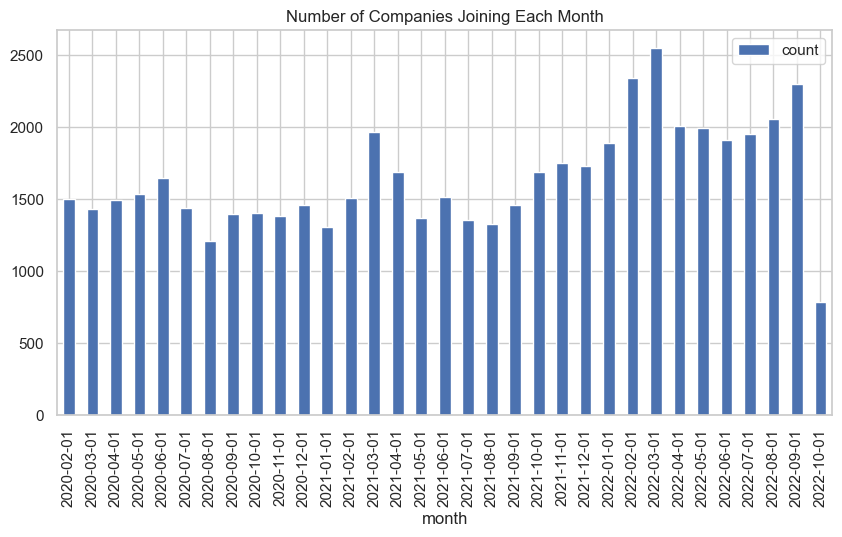

In [458]:
# plot number of companies joing each month; make sure to eliminate companies without join_date

def plot_joining_companies():
    df = pd.read_sql(
        get_dim_companies() + """ 
        select 
            date_trunc('month', date(join_date)) as month
            , count(distinct company_user_id) as count 
        from dim_comp 
        where join_date is not NULL
        and date(join_date) >= date('2020-02-01')
        group by 1 order by 1""", 
        conn)
    # df['month'] = df['month'].dt.strftime('%Y-%m')
    df.plot(x='month', y='count', kind='bar', figsize=(10,5), title='Number of Companies Joining Each Month')

plot_joining_companies()


In [356]:
# how many are still live?
pd.read_sql('with data as (' + get_dim_companies() + ') select count(distinct company_user_id) from data where is_still_live = 1 and join_date is not NULL', conn)

,_col0
0,38021


In [359]:
# company counts by countries:
pd.read_sql('with data as (' + get_dim_companies() + ') select country, count(distinct company_user_id) from data where is_still_live = 1 group by country', conn)

,country,_col1
0,Other,24
1,NZ,105
2,CA,2039
3,DE,794
4,GB,2113
5,IT,970
6,IE,146
7,AU,1016
8,RU,273
9,JP,465


array([[<AxesSubplot:title={'center':'survived_days'}>]], dtype=object)

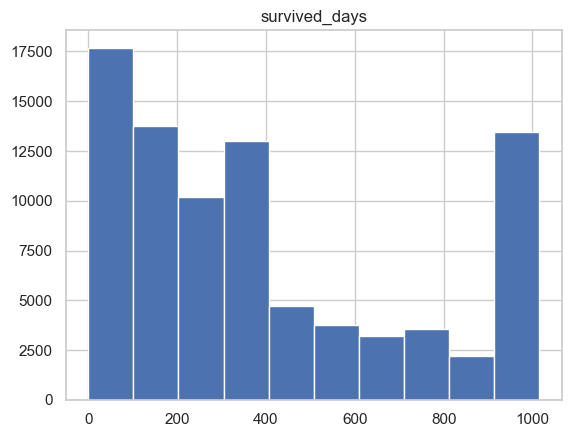

In [360]:
# get distribution of survived days
pd.read_sql('with data as (' + get_dim_companies() + ') select survived_days from data where survived_days is not NULL', conn).hist()

array([[<AxesSubplot:title={'center':'pre_activation_days'}>]],
      dtype=object)

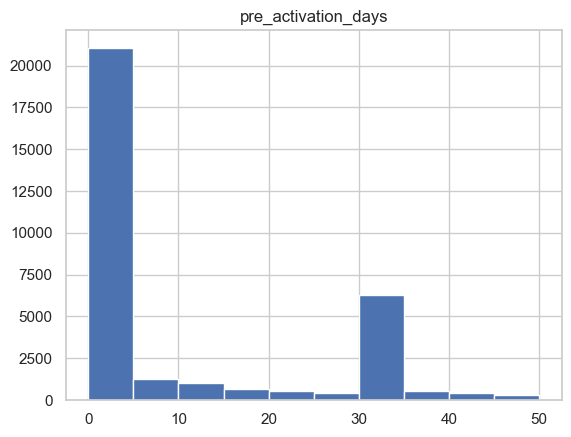

In [368]:
# distribution of pre activation days
pd.read_sql('with data as (' + get_dim_companies() + ') select pre_activation_days from data where pre_activation_days between 0 and 50 and is_still_live = 1', conn).hist()

In [413]:
# join valid fp table with company table:

def valid_fp_company(time_frame = '2020-01-01'): 
    sql = '''
    -- get valid floorplans
    with fp as (
        select floorplan_id, company_user_id, created_dt, created_at
            , count(floorplan_element_id) over (partition by floorplan_id) as fp_elements
            , min(date(created_dt)) over (partition by floorplan_id) as fp_created_dt 
            -- get 1 row per flooplan id
            , row_number() over (partition by floorplan_id) as row_num
        from gaia.dim_floorplan_elements 
        )
    , fp1 as (select floorplan_id, company_user_id, created_dt, fp_created_dt, fp_elements
        , case when fp_elements > 9 then 'valid' else 'invalid' end as fp_status
        , coalesce(date_diff('minute', lag(created_at) over(partition by company_user_id order by created_at), created_at), 2) as minutes_since_prev
    from fp
    where fp_elements > 9
    and row_num = 1
    order by floorplan_id, fp_created_dt
    )

    -- exclude floorplans within 1 minute of previous one
    , val_fp as (
        select * from fp1 where minutes_since_prev >1
        )

    -- get company info
    -- need to worry about renewals


    , dim_comp as (
        select company_user_id, join_date 
        from (
            select company_user_id, start_dt as join_date 
            from (
                -- dim_company_user_sku_ranges provides start_dt, country, sku, and free_or_paying
                -- dim_company_users has ivy_company_type and is_likely_houzzer 
                select  s.company_user_id
                    , s.start_dt 
                    , account_created_date
                    , row_number() over(PARTITION BY s.company_user_id
                                        ORDER BY start_dt ASC) AS row_num
                from gaia.dim_company_user_sku_ranges s 
                join gaia.dim_company_users c 
                on s.company_user_id = c.company_user_id
                where free_or_paying = 'paying'
                    and NOT c.is_likely_houzzer 
                    and c.ivy_company_type <> 'Not in ivy'
                )a
            where row_num = 1
            )b
        where date(join_date) >= date('{}')
    )

    -- get ft_date as first day in free trial status
    , ft as ( 
        select company_user_id, sku, country, pro_type, first_start_date, zip, metro_area, free_or_paying 
        from (
            select *,  start_dt as first_start_date
            from (
                select  s.*, zip, metro_area
                    --s.company_user_id, 
                    --start_dt,
                    --sku,
                    , case when country = 'AU' then 'AU'
                        when country = 'CA' then 'CA'
                        when country = 'DE' then 'DE'
                        when country = 'ES' then 'ES'
                        when country = 'FR' then 'FR'
                        when country = 'GB' then 'GB'
                        when country = 'IE' then 'IE'
                        when country = 'IT' then 'IT'
                        when country = 'JP' then 'JP'
                        when country = 'NZ' then 'NZ'
                        when country = 'RU' then 'RU'
                        when country = 'US' then 'US'
                        else 'Other' end as country

                    , ivy_company_type as pro_type 
                    , row_number() over(PARTITION BY s.company_user_id
                                        ORDER BY start_dt ASC) AS row_num
                            
                from gaia.dim_company_user_sku_ranges s 
                join gaia.dim_company_users c 
                on s.company_user_id = c.company_user_id
                where --free_or_paying <> 'paying' and 
                        NOT c.is_likely_houzzer 
                        and c.ivy_company_type <> 'Not in ivy'
                )a
        where row_num = 1
        )b
    )

    -- most recent is_still_live status
    , live as (
        select company_user_id, is_still_live
        from (  
            select *
            , row_number() over(PARTITION BY company_user_id ORDER BY end_dt DESC) AS row_num
            from gaia.dim_company_user_sku_ranges
            )a
        where row_num = 1
        )

    -- if paying customers are no longer live, get their last live date
    , last_live as (
        select company_user_id, end_dt as last_live_date
        from (  
            select *
            , row_number() over(PARTITION BY company_user_id ORDER BY end_dt DESC) AS row_num
            from gaia.dim_company_user_sku_ranges
            where free_or_paying = 'paying'
            )a
        where row_num = 1
        )        
    -- distinguish between companies who ever did free try
    ,first as (
        select ft.company_user_id, ft.country, ft.first_start_date, comp.join_date, ft.pro_type, ft.zip, ft.metro_area
            , case when first_start_date >= join_date then 'joined' else free_or_paying end as first_status
            , is_still_live, last_live_date

            -- pre activation days
            , date_diff('day', date(first_start_date), date(join_date)) as pre_activation_days
            -- activated days: use last live date if not live, othwerwise use today
            , date_diff('day', date(join_date),
                case when is_still_live = 1 then current_date
                else date(last_live_date) end) as survived_days
        from ft -- include both ft and never-joined companies
        left join dim_comp comp 
        on comp.company_user_id = ft.company_user_id
        left join live
        on live.company_user_id = ft.company_user_id
        left join last_live
        on last_live.company_user_id = ft.company_user_id
        
    ) 

    '''.format(time_frame)    
    return sql

In [485]:
# get number of valid floorplans over time and plot by company paying status
def valid_fp_over_time():
    sql = valid_fp_company() + '''
    -- join val_fp and first by company_user_id
    -- floor status = free if its date was before join_date or after last_live_date
    -- floor status = paying if its date was between join_date and last_live_date
    ,df as (
        select 
            first.*
            , floorplan_id, fp_created_dt, fp_status, minutes_since_prev
            , case 
                when date(fp_created_dt) between date_add('day', -30, date(join_date)) and date(join_date) then  '1:free trial (converted)'
                when date(fp_created_dt) between date(join_date) and date_add('day', 30, date(join_date)) then  '2:0-30d payment'
                when date(fp_created_dt) between date_add('day', 31, date(join_date)) and date_add('day', 90, date(join_date)) then  '3:30-90d payment'
                when date(fp_created_dt) between date_add('day', 91, date(join_date)) and date_add('day', 365, date(join_date)) then  '4:90d-1yr payment'
                when date(fp_created_dt) between date_add('day', 366, date(join_date)) and date(last_live_date) then  '5:1y+ payment'
                else '0:free' end as fp_paying_status
        from first
        left join val_fp
        on first.company_user_id = val_fp.company_user_id
        where fp_status = 'valid'
            --and country = 'US'
        order by first.company_user_id, fp_created_dt
    )

    -- count number of fp created per month
    ,df2 as (
        select
            date_trunc('month', fp_created_dt) as month
            , count(distinct floorplan_id) as num_fp
        from df
        group by 1
        order by 1
    )

    -- count number of fp created per month by company paying status
    ,df3 as (
        select
            date_trunc('month', fp_created_dt) as month
            , fp_paying_status
            , count(distinct floorplan_id) as num_fp
        from df
        group by 1, 2
        order by 1, 2
    )

    -- count number of distinct companies per month by fp paying status
    ,df4 as (
        select
            date_trunc('month', fp_created_dt) as month
            , fp_paying_status
            , count(distinct company_user_id) as num_company
        from df
        group by 1, 2
        order by 1, 2
    )

    -- aggreate fp counts per company per month by fp paying status
    ,df5 as (
        select
            company_user_id
            , date_trunc('month', fp_created_dt) as month
            , min(fp_paying_status) as fp_paying_status
            , count(distinct floorplan_id) as num_fp
        from df
        group by 1, 2

    )

    -- count companies by number of fp created per month by fp paying status
    ,df6 as (
        select
            month
            , fp_paying_status
            , num_fp
            , count(distinct company_user_id) as num_company
        from df5
        group by 1, 2, 3
        order by 1, 2, 3
    )

    -- average number of floorplans per comany per month by fp paying status and type
    ,df7 as (
        select
            company_user_id
            , date_trunc('month', fp_created_dt) as month
            , min(pro_type) as pro_type
            , count(distinct floorplan_id) as num_fp
        from df
        group by 1, 2
    )
    --,df8 as (
    --    select
    --        month
    --        , fp_paying_status
    --        , pro_type
    --        , avg(num_fp) as avg_num_fp
    --    from df7
    --    group by 1, 2, 3
    --    order by 1, 2, 3
    --)


    '''
    return sql


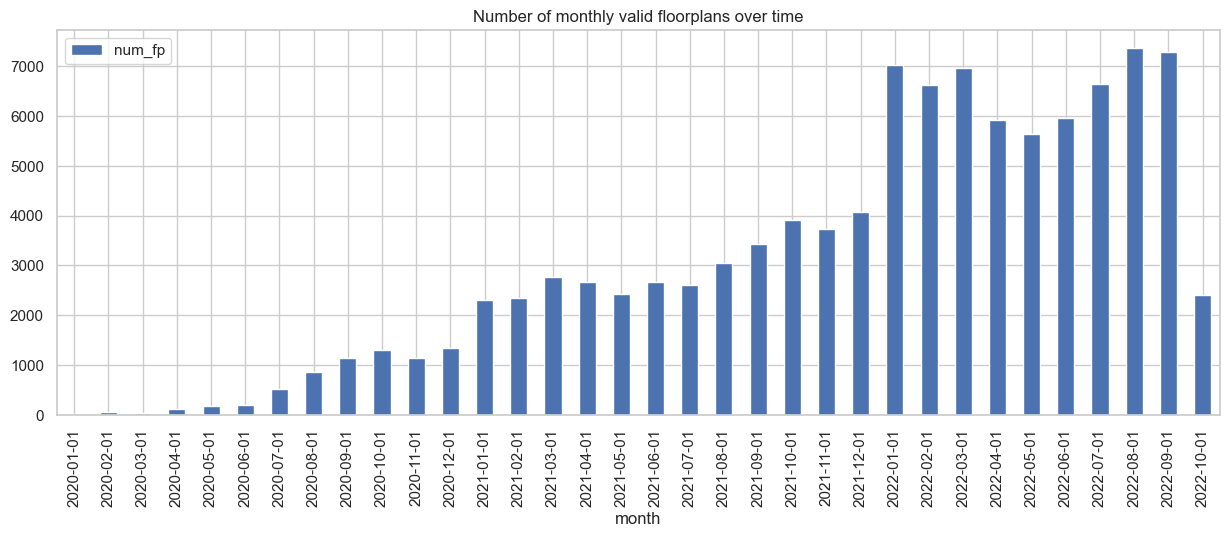

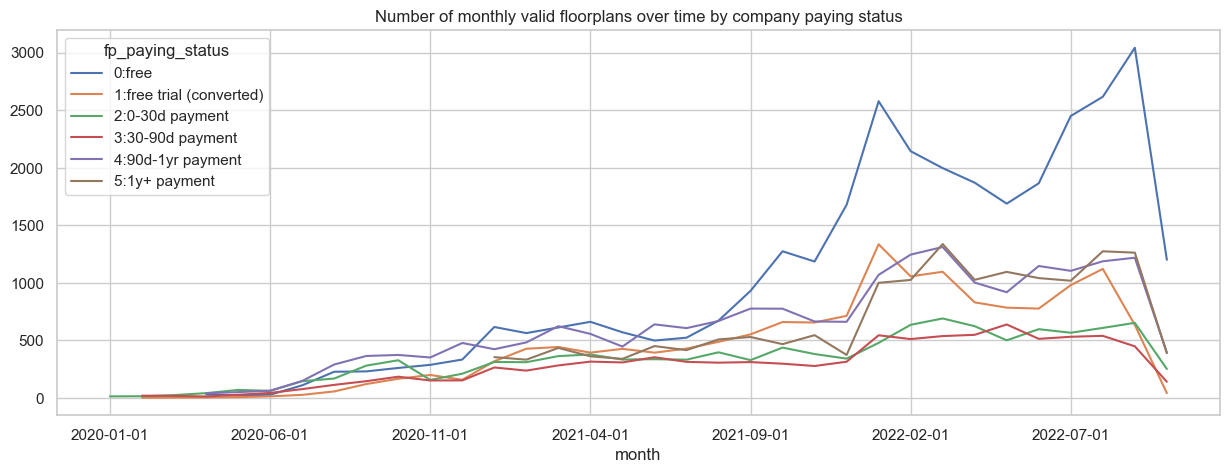

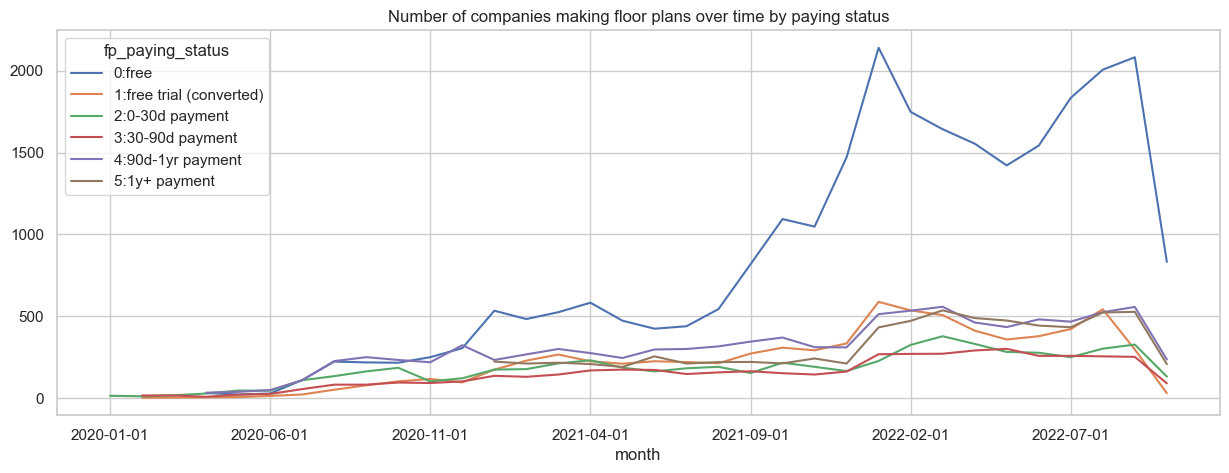

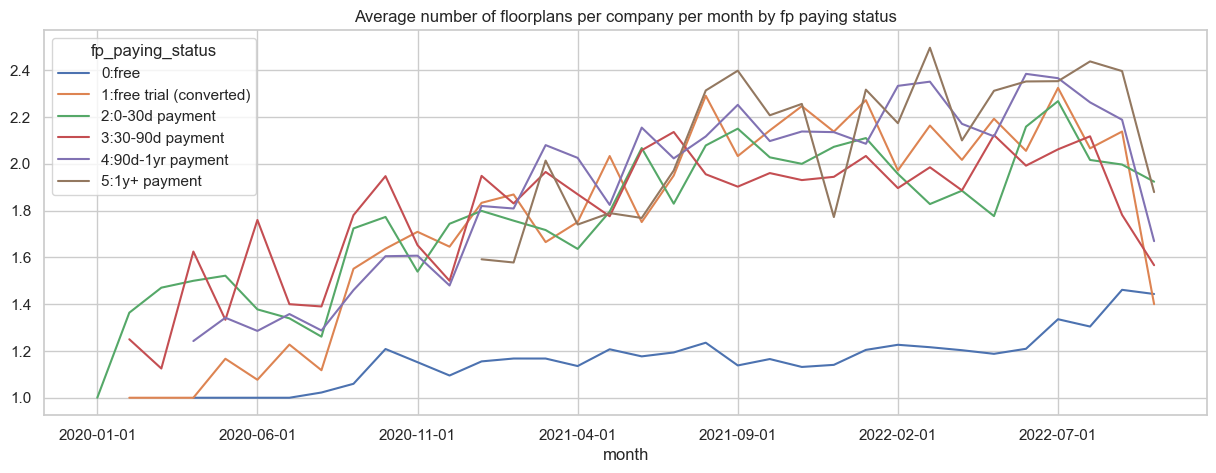

In [464]:
    # plot monthy number of valid floorplans

def plot_valid_fp_companies_over_time():
        df2 = pd.read_sql(valid_fp_over_time()+''' select * from df2 ''', con=conn)
        df2['month'] = df2['month'].astype(str)
        df2['num_fp'] = df2['num_fp'].astype(int)
        df2 = df2.sort_values(by='month')
        df2 = df2.set_index('month')
        df2.plot(kind='bar', figsize=(15,5), title='Number of monthly valid floorplans over time')

        # plot monthy number of valid floorplans by company paying status
        df3 = pd.read_sql(valid_fp_over_time()+''' select * from df3 ''', con=conn)

        df3['month'] = df3['month'].astype(str)
        df3['num_fp'] = df3['num_fp'].astype(int)
        df3 = df3.sort_values(by='month')
        df3 = df3.set_index('month')
        # make line plot
        df3.pivot(columns='fp_paying_status', values='num_fp').plot(figsize=(15,5), title='Number of monthly valid floorplans over time by company paying status')

        # plot monthly number of companies by fp paying status
        df4 = pd.read_sql(valid_fp_over_time()+''' select * from df4 ''', con=conn)
        df4['month'] = df4['month'].astype(str)
        df4['num_company'] = df4['num_company'].astype(int)
        df4 = df4.sort_values(by='month')
        df4 = df4.set_index('month')
        # line plot
        df4.pivot(columns='fp_paying_status', values='num_company').plot(figsize=(15,5), title='Number of companies making floor plans over time by paying status')

        # average number of floorplans per company per month by fp paying status
        # join df3 and df4
        df3['num_company'] = df4['num_company']
        df3['avg_num_fp'] = df3['num_fp']/df3['num_company']
        df3.pivot(columns='fp_paying_status', values='avg_num_fp').plot(figsize=(15,5), title='Average number of floorplans per company per month by fp paying status')

plot_valid_fp_companies_over_time()


/var/folders/cx/xbps_w2d2hq0mrf6fqn4nnxw0000gp/T/ipykernel_84925/374968129.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df6paying['num_fp'] = df6paying['num_fp'].apply(lambda x: 5 if x > 5 else x)
/var/folders/cx/xbps_w2d2hq0mrf6fqn4nnxw0000gp/T/ipykernel_84925/374968129.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df6paying['num_fp'] = df6paying['num_fp'].apply(lambda x: 5 if x > 5 else x)
/var/folders/cx/xbps_w2d2hq0mrf6fqn4nnxw0000gp/T/ipykernel_84925/374968129.py:13: SettingWithCopyWarni

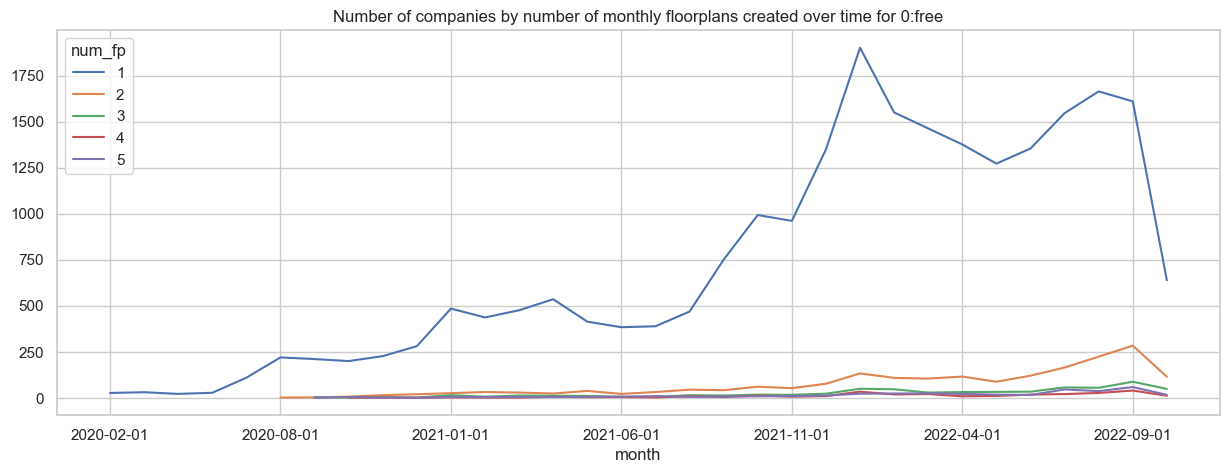

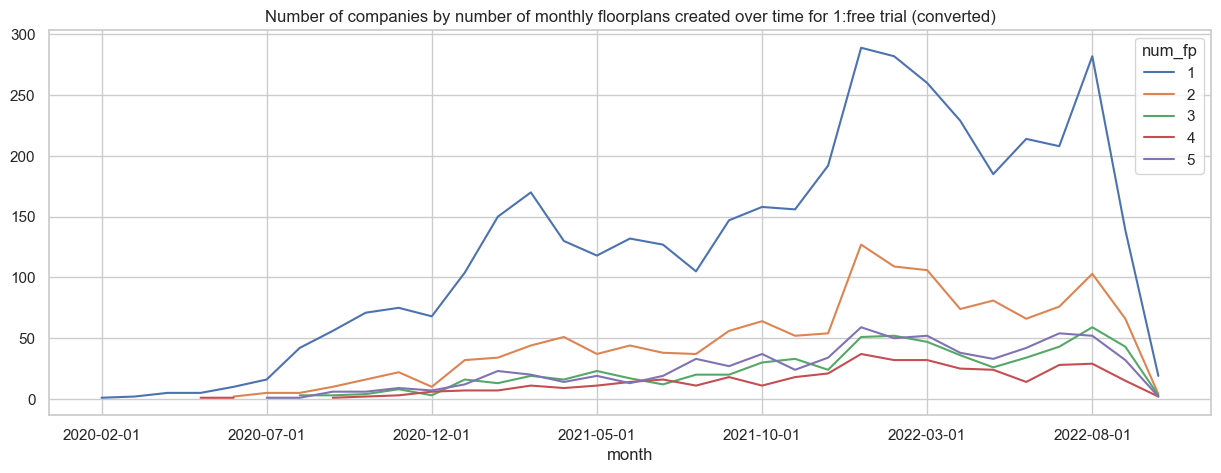

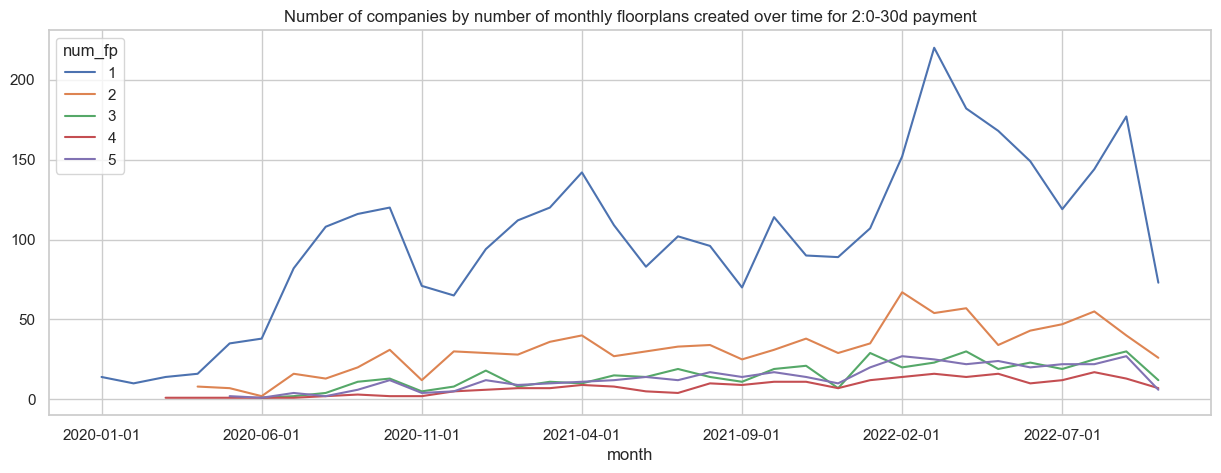

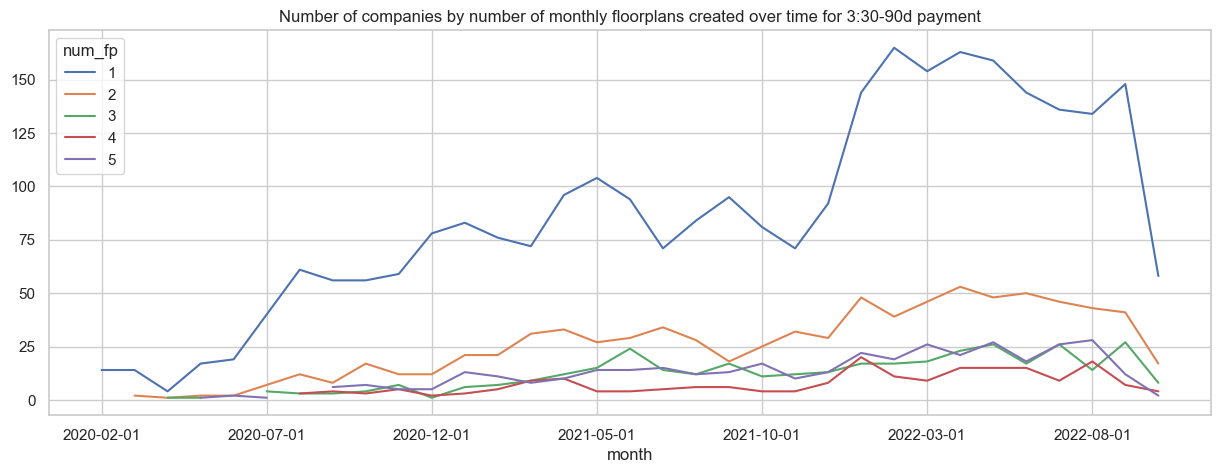

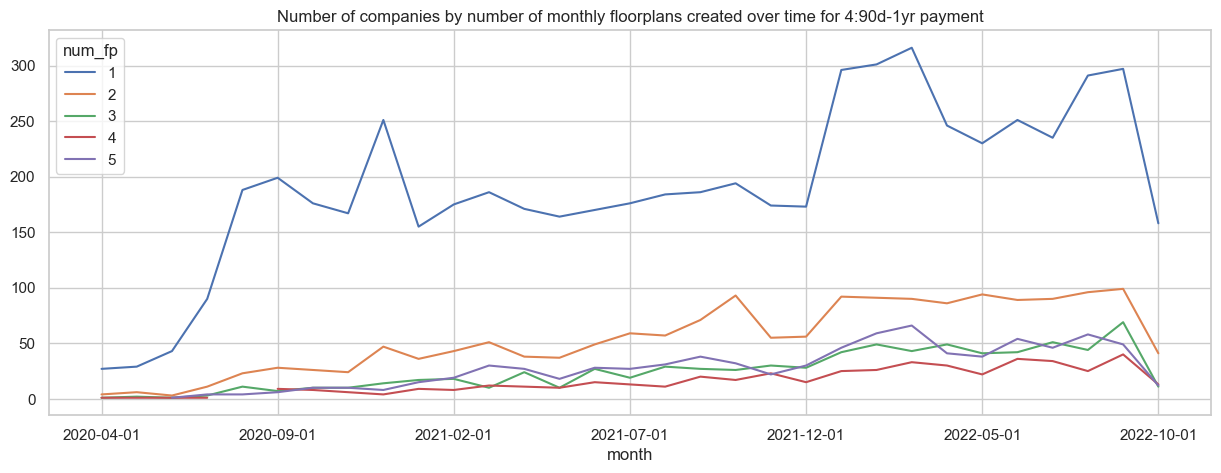

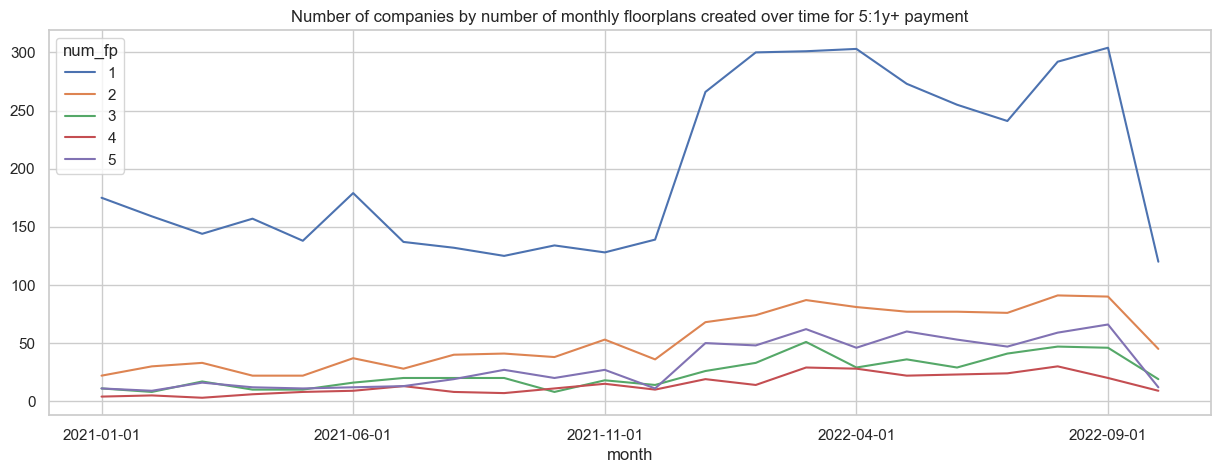

In [465]:
# for a given paying status, put companies into buckets by number of floorplans created per month, then plot the number of companies in each bucket over time

def plot_valid_fp_companies_over_time_by_paying_status():
    sql = valid_fp_over_time()
    # from df6 retain only paying companies, cap number of fp 5 and plot company counts by number of fp created over months
    df6 = pd.read_sql(sql+'''
    select * from df6
    ''', con=conn)

    for paying_status in sorted(df6['fp_paying_status'].unique()):
        df6paying = df6[df6['fp_paying_status'] == paying_status]
        # if number of fp is greater than 5, sum up all companies with more than 5 fp
        df6paying['num_fp'] = df6paying['num_fp'].apply(lambda x: 5 if x > 5 else x)
        df6paying = df6paying.groupby(['month', 'num_fp']).sum().reset_index()
        df6paying['month'] = df6paying['month'].astype(str)
        df6paying['num_company'] = df6paying['num_company'].astype(int)
        df6paying = df6paying.sort_values(by='month')
        df6paying = df6paying.set_index('month')
        # make line plot
        df6paying.pivot(columns='num_fp', values='num_company').plot(kind='line', figsize=(15,5), title='Number of companies by number of monthly floorplans created over time for {0}'.format(paying_status))




    # from df8, retain paying companies, plot average number of fp created per company for each pro type over time
    # df8paying = pd.read_sql(sql+'''
    # select * from df8
    # where fp_paying_status = '{0}'
    # '''.format(paying_status), con=conn)
    # df8paying['month'] = df8paying['month'].astype(str)
    # df8paying['avg_num_fp'] = df8paying['avg_num_fp'].astype(float)
    # df8paying = df8paying.sort_values(by='month')
    # df8paying = df8paying.set_index('month')
    # df8paying.pivot(columns='pro_type', values='avg_num_fp').plot(kind='line', figsize=(15,5), title='Average number of floorplans created per paying company over time for {0}'.format(paying_status))

plot_valid_fp_companies_over_time_by_paying_status()

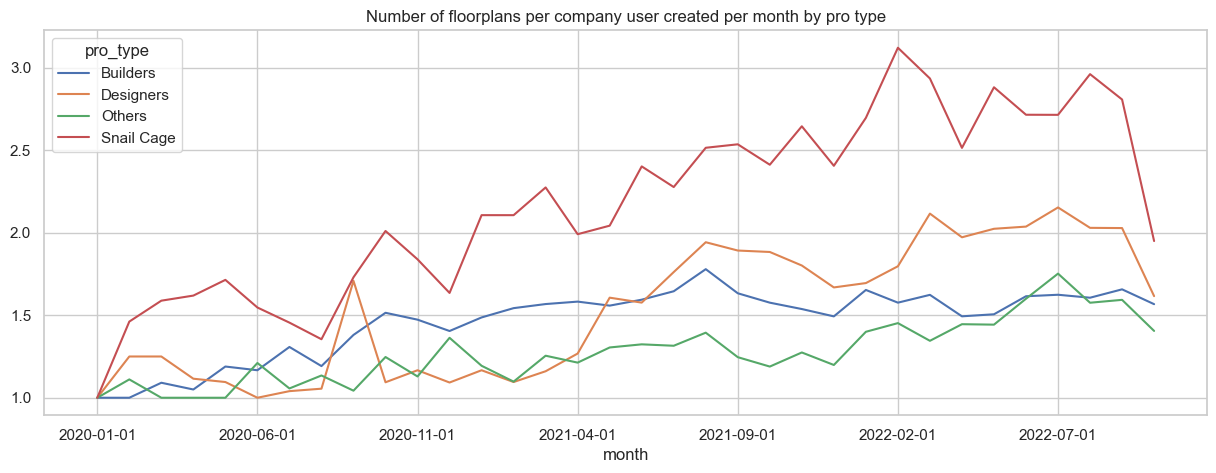

In [494]:
    # from df8, retain paying companies, plot average number of fp created per company for each pro type over time

def plot_avg_fp_per_company_pro_type_monthly():
        sql = valid_fp_over_time()
        df = pd.read_sql(sql+''' select * from df7 ''', con=conn)
        # aggregate df7 by month, and pro_type
        df7 = df.groupby(['month', 'pro_type'])['num_fp' ].mean().reset_index()
        df7['month'] = df7['month'].astype(str)
        df7 = df7.sort_values(by='month')
        df7 = df7.set_index('month')
        # make line plot
        df7.pivot(columns='pro_type', values='num_fp').plot(kind='line', figsize=(15,5), title='Number of floorplans per company user created per month by pro type')
     



plot_avg_fp_per_company_pro_type_monthly()

## conclusion

these counts are for ALL customers, including many who are not paying

current data made accessible to Sean Corriel (PM) filter out only paying customers